In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pvlib
import sklearn
from sklearn.preprocessing import MinMaxScaler

# Set random seed for reproducibility
torch.manual_seed(42)

In [2]:
# Load the dataset from data/ with timezone correction
import os
import pandas as pd
from pytz import timezone


import os
import pandas as pd
from pytz import timezone

def load_and_fix_timestamps(data_dir='data'):
    """
    Load CSV files, handle special NAM file format, 
    and set timestamps to UTC.
    """
    data_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
    dfs = {}

    for file in data_files:
        df_name = file.replace('.csv', '').replace('-', '_')
        file_path = os.path.join(data_dir, file)
        
        try:
            # --- FIX: Handle the special format of NAM files ---
            if 'Folsom_NAM' in file:
                # Skip the first descriptive row and parse 'valtime' as the index
                df = pd.read_csv(
                    file_path, 
                    skiprows=1, 
                    parse_dates=['valtime'],
                    index_col='valtime'
                )
            else:
                # Original logic for other files
                df = pd.read_csv(file_path, parse_dates=[0], index_col=0)

            # --- FIX: Ensure the index is timezone-aware UTC ---
            if df.index.tz is None:
                # Localize the naive timestamp index to UTC
                df.index = df.index.tz_localize('UTC')
                print(f"✓ Set timezone to UTC for {file}")
            else:
                print(f"ℹ {file} already has timezone info")

            dfs[df_name] = df
            print(f"Loaded {file} into dfs['{df_name}']")

        except Exception as e:
            print(f"Could not process file {file}: {e}")

    return dfs


# Load all datasets with timezone correction
dfs = load_and_fix_timestamps()

# Display summary of loaded files
print("\n -------------------- Loaded Datasets --------------------")
for name, df in dfs.items():
    timestamp_col = df.columns[0]
    # Show timezone info if available
    tz_info = ""
    if hasattr(df[timestamp_col].dtype, 'tz') and df[timestamp_col].dt.tz is not None:
        tz_info = f" (timezone: {df[timestamp_col].dt.tz})"

    print(f"\n{name}: {df.shape[0]} rows {df.shape[1]} columns{tz_info}")

    # Show sample timestamps to verify conversion
    if len(df) > 0:
        first_time = df[timestamp_col].iloc[0]
        last_time = df[timestamp_col].iloc[-1]
        print(f"  Time range: {first_time} to {last_time}")

✓ Set timezone to UTC for Irradiance_features_intra-hour.csv
Loaded Irradiance_features_intra-hour.csv into dfs['Irradiance_features_intra_hour']
✓ Set timezone to UTC for Folsom_NAM_lat38.599891_lon-121.126680.csv
Loaded Folsom_NAM_lat38.599891_lon-121.126680.csv into dfs['Folsom_NAM_lat38.599891_lon_121.126680']
✓ Set timezone to UTC for Target_intra-day.csv
Loaded Target_intra-day.csv into dfs['Target_intra_day']
✓ Set timezone to UTC for Folsom_irradiance.csv
Loaded Folsom_irradiance.csv into dfs['Folsom_irradiance']
✓ Set timezone to UTC for Target_intra-hour.csv
Loaded Target_intra-hour.csv into dfs['Target_intra_hour']
✓ Set timezone to UTC for Irradiance_features_intra-day.csv
Loaded Irradiance_features_intra-day.csv into dfs['Irradiance_features_intra_day']
✓ Set timezone to UTC for Sky_image_features_intra-hour.csv
Loaded Sky_image_features_intra-hour.csv into dfs['Sky_image_features_intra_hour']
✓ Set timezone to UTC for Folsom_NAM_lat38.683880_lon-121.286556.csv
Loaded Fols

In [3]:
# Display the names of all loaded DataFrames
for i, f in enumerate(dfs.keys()):
    print(f"File {i}: {f}")

File 0: Irradiance_features_intra_hour
File 1: Folsom_NAM_lat38.599891_lon_121.126680
File 2: Target_intra_day
File 3: Folsom_irradiance
File 4: Target_intra_hour
File 5: Irradiance_features_intra_day
File 6: Sky_image_features_intra_hour
File 7: Folsom_NAM_lat38.683880_lon_121.286556
File 8: Irradiance_features_day_ahead
File 9: Folsom_satellite
File 10: NAM_nearest_node_day_ahead
File 11: Folsom_weather
File 12: Target_day_ahead
File 13: Sat_image_features_intra_day
File 14: Folsom_NAM_lat38.579454_lon_121.260320
File 15: Folsom_NAM_lat38.704328_lon_121.152788


In [4]:
dfs['Folsom_irradiance']

,ghi,dni,dhi
timeStamp,,,
2014-01-02 08:00:00+00:00,0.0,0.0,0.0
2014-01-02 08:01:00+00:00,0.0,0.0,0.0
2014-01-02 08:02:00+00:00,0.0,0.0,0.0
2014-01-02 08:03:00+00:00,0.0,0.0,0.0
2014-01-02 08:04:00+00:00,0.0,0.0,0.0
...,...,...,...
2016-12-31 07:55:00+00:00,0.0,0.0,0.0
2016-12-31 07:56:00+00:00,0.0,0.0,0.0
2016-12-31 07:57:00+00:00,0.0,0.0,0.0


1. Target_day_ahead File
    - This file contains the actual ground truth values that forecasting models aim to predict for day-ahead horizons (26-39 hours ahead).
    - Hourly records for ghi/dni/ghi_kt/dni_kt/ghi_clear/dni_clear/elevation
2. Irradiance_features_day_ahead File
    - This contains endogenous features engineered from historical irradiance measurements (the actual irradiance observations), computed from the previous 8-20 hours before the forecast issuing time.
        - B(ghi_kt|Xh): Backward average of GHI clear-sky index over X-hour window
        - L(ghi_kt|Xh): Lagged average of GHI clear-sky index
        - V(ghi_kt|Xh): Variability (standard deviation) of GHI clear-sky index.

3. Folsom_irradiance :
    - 1-minute resolution measurements from sensors
    - GHI, DNI, DHI values
    - Three years: 2014-2016
    - Raw ground truth data
    - **We need this file to create historical features (past N hours)**

4. NAM_nearest_node_day_ahead:
    - This is the NAM predicted values based on the neasrest point to Folsom which around 4km, so this will be our benchmark model.
    - NAM predictions from the closest grid point to Folsom
    - NAM GHI forecast (DSWRF)
    - NAM cloud cover (TCDC)
    - For horizons 26-39 hours ahead
    - Issued at 12:00 UTC daily

5. Folsom_NAM_lat38.XXXXX_lon_XXX.XXXXX (4 files):
    - NAM data from the four nearest grid points.
    - Same variables as NAM_nearest_node
    - From slightly different locations around Folsom
    - **Using multiple grid points can improve forecasts, Provides spatial context**

6. Target_day_ahead:
    - Actual measured values we want to predict.
    - ghi_26h, ghi_27h, ... ghi_39h (real sensor measurements).
    - dni_26h, dni_27h, ... dni_39h
    - Clear-sky values: ghi_clear_26h, etc.
    - Clear-sky indices: ghi_kt_26h, etc.
    - Solar elevation angles: elevation_26h, etc.

7. Folsom_weather
    - 1-minute weather measurements from sensors
    - Temperature, humidity, pressure, wind speed, precipitation
    - Colocated with irradiance sensors
    - We will feed the model with NAM predictions from different locations instead.

8. Folsom_sky_image_features
    - Features extracted from ground-based sky camera
    - Average, standard deviation, entropy of RGB channels
    - 1-minute resolution
    - **Too short-term for 26-39 hour predictions**

comparing NAM (North American Mesoscale) NWP forecasts as the baseline benchmark for day-ahead forecasts against Models i will create


What is the model?
- Past Knowledge: Irradiance measurements (Endogenous (Historical sensor data)) from 8-20 hours BEFORE the issuing time
    - Endogenous features: Historical clear-sky index patterns from past 8-20h
        - Shows recent variability, trends
- Future Knowledge: (Exogenous (NWP forecasts)) NAM predictions 26-39 hours AHEAD of the issuing time, GHI forecast, cloud cover, temperature.
    - NWP models (like NAM) run complex physical atmospheric simulations to predict future weather:
        - They use current atmospheric observations from satellites, weather stations, radiosonde balloons
        - They solve fluid dynamics equations to simulate how the atmosphere will evolve
        - They predict cloud formation, movement, and properties for future time periods
        - They output forecasts for many variables including solar irradiance, cloud cover, etc.
        - NAM predicted GHI, cloud cover, temperature, humidity for +26h to +39h

        ```
        Timeline:
        ├─────────────┼─────────────┼─────────────┤
        -20h         -8h      NOW (0h)        +26h to +39h
                    [Historical]           [What you want to predict]
                    [Sensor Data]

        At NOW (12:00 UTC):
        - You have: Past 8-20h of sensor measurements (endogenous)
        - You have: NAM forecasts for +26h to +39h (exogenous)
        - You want: Actual irradiance for +26h to +39h (target)

        ```
    - NAM Includes the following:
        - DSWRF - NAM's GHI forecast (W/m²)
        - TCDC - Total cloud cover (%)
        - Temperature
        - Humidity
        - Wind speed (U and V components)
        - Pressure
        - Precipitation
Why such combination?
- combining endogenous features (historical irradiance) with NAM forecasts as exogenous features significantly improves forecast skill by 31-34% for GHI and 21-23% for DNI compared to using raw NAM forecasts alone.


- #### Simple:
Input features:
- Past GHI, DNI (from sensors)
- NAM_GHI_forecast (future)
- NAM_temperature (future)
- NAM_humidity (future)
- NAM_cloud_cover (future)
- NAM_wind_speed (future)
- Clear_sky_GHI (computed)

Output (what model predicts):
- GHI_48h_ahead  ← ONLY THIS

Loss function:
loss = MSE(predicted_GHI, actual_GHI)



What is the Plan?
1. Phase 1: Simple Baseline
    - Inputs:
        - Historical sequence: 3 Days (Before Issuing) × 3 features (ghi_kt , elevation)
            - GHI_kt,
            - Elevation
        - NAM: Nearest grid point only (26-39 horizons ahead  (1 day) × 2 features) (From Issue Time)
            - NAM GHI forecast (DSWRF)
            - NAM cloud cover (TCDC)
    - Output:
        - Day ahead (GHI -> GHI_kt)
    - Simple LSTM 
    - Bench mark is the NAM forecasting for nearest Location, Smart Persistence.
2. Phase 2: Simple Baseline + Temporal features enrichment
    - Inputs:
        - Historical sequence: 3 Days (Before Issuing) × 3 features (ghi_kt , elevation)
            - GHI_kt,
            - Elevation
            - Temporal Features.
        - NAM: Nearest grid point only (26-39 horizons ahead  (1 day) × 2 features) (From Issue Time)
            - NAM GHI forecast (DSWRF)
            - NAM cloud cover (TCDC)
    - Output:
        - Day ahead (GHI -> GHI_kt)
    - Simple LSTM 
    - Bench mark is the NAM forecasting for nearest Location, Smart Persistence.

3. Phase 3: Add Images features as Statistical 
    - Inputs:
        - Historical sequence: 3 Days (Before Issuing) × 3 features (ghi_kt , elevation)
            - GHI_kt,
            - Elevation
            - Temporal Features.
            - Sky Images as input
                - sky images are primarily useful for intrahour forecasting
        - NAM: Nearest grid point only (26-39 horizons ahead  (1 day) × 2 features) (From Issue Time)
            - NAM GHI forecast (DSWRF)
            - NAM cloud cover (TCDC)
    - Output:
        - Day ahead (GHI -> GHI_kt)
    - Simple LSTM 
    - Bench mark is the NAM forecasting for nearest Location, Smart Persistence.

2. Phase 4: Add Spatial Information
    - Inputs:
        - Historical sequence: 3 Days × 3 features (ghi_kt , elevation)
            - GHI_kt,
            - Elevation
        - NAM: All 4 grid points (26-39 hours ahead horizon (1 day- 14 Horizons) × 2 features), From Issuing Time (4:00 AM PST), 00:00 UTC.
            - NAM GHI forecast (DSWRF)
            - NAM cloud cover (TCDC)
    - Output:
        - Day ahead (GHI -> GHI_kt)
    - Simple LSTM 
    - Bench mark is the NAM forecasting for nearest Location, Smart Persistence.

2. Phase 5: Complex Model
    - Inputs:
        - Historical sequence: 3 Days × 3 features (ghi_kt , elevation)
            - GHI_kt,
            - Elevation
            - Other selected Featrues(...).
        - NAM: All 4 grid points (26-39 hours ahead horizon (1 day- 14 Horizons) × 2 features), From Issuing Time (4:00 AM PST), 00:00 UTC.
            - NAM GHI forecast (DSWRF)
            - NAM cloud cover (TCDC)
    - Output:
        - Day ahead (GHI -> GHI_kt)
    - Mamba Model 
    - Bench mark is the NAM forecasting for nearest Location, LSTM.

    2. Phase 6: Physics informed State Space Model (Mamba + Physics)
    - Inputs:
        - Historical sequence: 3 Days × 3 features (ghi_kt , elevation)
            - GHI_kt,
            - Elevation
            - Other selected Featrues(...).
        - NAM: All 4 grid points (26-39 hours ahead horizon (1 day- 14 Horizons) × 2 features), From Issuing Time (4:00 AM PST), 00:00 UTC.
            - NAM GHI forecast (DSWRF)
            - NAM cloud cover (TCDC)
    - Output:
        - Day ahead (GHI -> GHI_kt)
    - Mamba Model 
    - Bench mark is the NAM forecasting for nearest Location, Mamba, LSTM.





In [5]:
dfs['Folsom_NAM_lat38.599891_lon_121.126680']

,reftime,dwsw,cloud_cover,precipitation,pressure,wind-u,wind-v,temperature,rel_humidity
valtime,,,,,,,,,
2014-01-02 14:00:00+00:00,2014-01-01 12:00:00,0.000,4.0,0.000,100674.0,-1.8269,-0.5652,273.254,43.0
2014-01-02 15:00:00+00:00,2014-01-01 12:00:00,0.000,2.0,0.000,100657.0,-1.8087,-0.3762,272.865,41.0
2014-01-02 16:00:00+00:00,2014-01-01 12:00:00,96.625,0.0,0.000,100686.0,-1.6095,-0.1018,277.300,39.0
2014-01-02 17:00:00+00:00,2014-01-01 12:00:00,272.750,0.0,0.000,100758.0,-1.0269,-0.0743,284.628,35.0
2014-01-02 18:00:00+00:00,2014-01-01 12:00:00,422.375,10.0,0.000,100769.0,0.1867,-0.2503,289.850,34.0
...,...,...,...,...,...,...,...,...,...
2017-01-01 23:00:00+00:00,2016-12-31 12:00:00,79.750,100.0,0.625,99900.0,1.3909,-0.1141,280.958,84.0
2017-01-02 00:00:00+00:00,2016-12-31 12:00:00,32.500,100.0,0.625,99923.0,1.3571,0.3261,280.208,84.0
2017-01-02 03:00:00+00:00,2016-12-31 12:00:00,0.000,100.0,0.000,99971.0,0.2590,1.7056,278.698,92.0


----

Convert NAM Wide formate into long formate. 

In [6]:
dfs['NAM_nearest_node_day_ahead']


,nam_ghi_26h,nam_ghi_27h,nam_ghi_28h,nam_ghi_29h,nam_ghi_30h,nam_ghi_31h,nam_ghi_32h,nam_ghi_33h,nam_ghi_34h,nam_ghi_35h,...,nam_cc_31h,nam_cc_32h,nam_cc_33h,nam_cc_34h,nam_cc_35h,nam_cc_36h,nam_cc_37h,nam_cc_38h,nam_cc_39h,nam_cc_40h
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-01-02 12:00:00+00:00,0.0,0.0,99.625,274.750,416.375,510.875,547.375,527.500,454.625,329.125,...,8.0,20.0,18.0,12.0,8.0,20.0,21.333333,22.666667,24.0,24.666667
2014-01-03 12:00:00+00:00,0.0,0.0,96.000,270.250,411.875,508.875,547.625,527.125,450.375,318.750,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
2014-01-04 12:00:00+00:00,0.0,0.0,107.250,281.625,428.125,525.000,563.875,541.875,462.500,328.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,15.333333
2014-01-05 12:00:00+00:00,0.0,0.0,91.875,277.125,418.625,509.375,524.875,537.750,310.500,308.000,...,84.0,98.0,74.0,100.0,100.0,100.0,100.000000,100.000000,100.0,100.000000
2014-01-06 12:00:00+00:00,0.0,0.0,105.000,286.000,429.500,518.250,557.250,543.000,469.125,344.000,...,0.0,0.0,34.0,40.0,20.0,2.0,1.333333,0.666667,0.0,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-26 12:00:00+00:00,0.0,0.0,75.625,232.750,365.125,453.625,484.875,453.750,366.750,230.875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
2016-12-27 12:00:00+00:00,0.0,0.0,74.500,232.375,367.125,455.375,486.750,457.375,371.500,235.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
2016-12-28 12:00:00+00:00,0.0,0.0,73.875,229.625,361.875,449.875,482.375,454.625,371.375,237.125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,22.666667


In [7]:
def expand_nam_to_hourly(nam_wide):
    """Convert wide NAM format to hourly target format"""
    
    records = []
    nam_wide_tmp = nam_wide.reset_index()
    for idx, row in nam_wide_tmp.iterrows():
        issue_time = row['timestamp']
        
        # For each horizon (26-40h)
        for h in range(26, 41):
            target_time = issue_time + pd.Timedelta(hours=h)
            
            record = {
                'issue_time': issue_time,
                'target_time': target_time,
                'horizon': h,
                'nam_ghi': row[f'nam_ghi_{h}h'],
                'nam_dni': row[f'nam_dni_{h}h'],
                'nam_cc': row[f'nam_cc_{h}h']
            }
            records.append(record)
    
    nam_long = pd.DataFrame(records)
    return nam_long



NAM_nearest_node_day_ahead_long = expand_nam_to_hourly(dfs['NAM_nearest_node_day_ahead'])

In [8]:
NAM_nearest_node_day_ahead_long.head()

,issue_time,target_time,horizon,nam_ghi,nam_dni,nam_cc
0,2014-01-02 12:00:00+00:00,2014-01-03 14:00:00+00:00,26,0.0,0.0,0.0
1,2014-01-02 12:00:00+00:00,2014-01-03 15:00:00+00:00,27,0.0,0.0,2.0
2,2014-01-02 12:00:00+00:00,2014-01-03 16:00:00+00:00,28,99.625,497.069277,2.0
3,2014-01-02 12:00:00+00:00,2014-01-03 17:00:00+00:00,29,274.75,760.162689,0.0
4,2014-01-02 12:00:00+00:00,2014-01-03 18:00:00+00:00,30,416.375,871.248807,2.0


#### <strong style="color:red">NOTE: Time Stamp is in UTC Timezone in all files. No conversion to Pacific Time is needed.</strong>

In [9]:
dfs["Folsom_irradiance"].head()

,ghi,dni,dhi
timeStamp,,,
2014-01-02 08:00:00+00:00,0.0,0.0,0.0
2014-01-02 08:01:00+00:00,0.0,0.0,0.0
2014-01-02 08:02:00+00:00,0.0,0.0,0.0
2014-01-02 08:03:00+00:00,0.0,0.0,0.0
2014-01-02 08:04:00+00:00,0.0,0.0,0.0


In [10]:
NAM_nearest_node_day_ahead_long.head()

,issue_time,target_time,horizon,nam_ghi,nam_dni,nam_cc
0,2014-01-02 12:00:00+00:00,2014-01-03 14:00:00+00:00,26,0.0,0.0,0.0
1,2014-01-02 12:00:00+00:00,2014-01-03 15:00:00+00:00,27,0.0,0.0,2.0
2,2014-01-02 12:00:00+00:00,2014-01-03 16:00:00+00:00,28,99.625,497.069277,2.0
3,2014-01-02 12:00:00+00:00,2014-01-03 17:00:00+00:00,29,274.75,760.162689,0.0
4,2014-01-02 12:00:00+00:00,2014-01-03 18:00:00+00:00,30,416.375,871.248807,2.0


#### Classify day and night using solar elevation angle

In [11]:
""" 

Some notes about the function below:
1. time_gap_norm is used to identify gaps in sensor reporting. If sensor stops reporting for 6 hours, this feature spikes → useful for flagging unreliable periods.

2. day_boundary_flag helps models learn daily cycles or detect midnight transitions.

3. is_daylight If sun is high enough (zenith < 85° → elevation > 5°), it’s considered "daylight". Because daylight hours change with season and latitude! In winter, 7 AM might still be dark; in summer, it’s bright. This method is physically accurate. 


"""

    
def calculate_solar_position(df, location_lat=38.642, location_lon=-121.148, 
                            location_timezone='America/Los_Angeles', 
                            zenith_threshold=85):
    """
    Calculate solar position and classify day/night records.
    Assumes input timestamps are in UTC (naive or timezone-aware).
    
    Parameters:
    -----------
    df : DataFrame with DatetimeIndex
    location_lat : float - Latitude of the location
    location_lon : float - Longitude of the location
    location_timezone : str - Timezone name for the location (used for reporting only)
    zenith_threshold : float - Solar zenith angle threshold for daylight (default 85°)
    
    Returns:
    --------
    DataFrame with added columns:
        - solar_zenith: Zenith angle (°)
        - solar_azimuth: Azimuth angle (°)
        - solar_elevation: Elevation angle (°) - negative means below horizon
        - is_daylight: Binary flag (1=day, 0=night)
    """
    import pvlib
    
    df = df.copy()
    
    # Ensure timeStamp is datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    # Properly handle UTC timestamps
    df_temp = df.reset_index()
    
    idx = df.index
    if idx.tz is None:
        time_utc = idx.tz_localize('UTC')
    else:
        time_utc = idx.tz_convert('UTC')

    # Local time vector for hour gating (no ambiguity)
    time_local = time_utc.tz_convert(location_timezone)
    
    # Calculate solar position using pvlib
    solar_pos = pvlib.solarposition.get_solarposition(
        time=time_utc,
        latitude=location_lat,
        longitude=location_lon
    )
    
    # Add solar features to dataframe
    df['solar_zenith'] = solar_pos['zenith'].values
    df['solar_azimuth'] = solar_pos['azimuth'].values
    df['solar_elevation'] = solar_pos['elevation'].values
    # Extract hour of day
    # Hour guard in LOCAL time: allow 0–4 and 14–23 only
    hours_local = time_local.hour
    allowed = (hours_local < 5) | (hours_local > 13)

    # Daylight = (sun criterion) AND (hour guard)
    # df['is_daylight'] = ((df['solar_zenith'] < zenith_threshold) & allowed).astype(float)
    df['is_daylight'] = (allowed).astype(float)

    
    # Verification statistics
    min_zenith = df['solar_zenith'].min()
    max_zenith = df['solar_zenith'].max()
    min_elevation = df['solar_elevation'].min()
    max_elevation = df['solar_elevation'].max()
    daylight_records = df['is_daylight'].sum()
    night_records = (df['is_daylight'] == 0).sum()
    total_records = len(df)
    
    print("="*60)
    print("SOLAR POSITION CALCULATION RESULTS")
    print("="*60)
    print(f"Location: ({location_lat}, {location_lon})")
    print(f"Timezone: {location_timezone}")
    print(f"Zenith threshold: {zenith_threshold}°")
    print(f"\nSolar Angles:")
    print(f"  Zenith range:    {min_zenith:6.1f}° to {max_zenith:6.1f}°")
    print(f"  Elevation range: {min_elevation:6.1f}° to {max_elevation:6.1f}°")
    print(f"\nRecord Classification:")
    print(f"  Total records:    {total_records:,}")
    print(f"  Daylight records: {daylight_records:,} ({daylight_records/total_records*100:5.1f}%)")
    print(f"  Night records:    {night_records:,} ({night_records/total_records*100:5.1f}%)")
    print("="*60)
    
    return df


def add_temporal_features(df, location_timezone='America/Los_Angeles', 
                         reference_start_time=None):
    """
    Add temporal features to the dataset accounting for existing time gaps.
    This should be applied AFTER filtering out night records.
    
    Parameters:
    -----------
    df : DataFrame with DatetimeIndex (typically daytime-only records)
    location_timezone : str - Timezone for local time calculations
    reference_start_time : Timestamp - Reference point for absolute_hour calculation
                          If None, uses first timestamp in dataset
    
    Returns:
    --------
    DataFrame with added columns:
        - time_gap_hours: Actual hours since previous record
        - time_gap_norm: Time gap normalized by 24 hours
        - day_boundary_flag: Binary flag indicating day change (in local time)
        - hour_progression: Hour of day in local time (0-24, continuous)
        - absolute_hour: Continuous hours from reference start time
    """
    import pandas as pd
    
    df = df.copy()
    
    # Ensure timeStamp is datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    # Properly handle UTC timestamps
    if df.index.tz is None:
        time_utc = df.index.tz_localize('UTC')
    else:
        time_utc = df.index.tz_convert('UTC')
    
    # Convert to local timezone for day-based features
    time_local = time_utc.tz_convert(location_timezone)
    
    # === FEATURE 1: Time Gap Indicators ===
    time_diffs = df.index.to_series().diff()
    gap_hours = time_diffs.dt.total_seconds() / 3600
    
    df['time_gap_hours'] = gap_hours
    df['time_gap_norm'] = gap_hours / 24.0  # Normalized by 24 hours
    
    # Fill first value with median gap (or 1 hour if you prefer)
    median_gap = gap_hours.median()
    df['time_gap_hours'].fillna(median_gap, inplace=True)
    df['time_gap_norm'].fillna(median_gap/24.0, inplace=True)
    
    # === FEATURE 2: Day Boundary Flags ===
    # Identify day boundaries using local time
    # Convert time_local to Series for proper manipulation
    time_local_series = pd.Series(time_local, index=df.index)
    
    # Calculate previous and current dates
    prev_times = time_local_series - time_diffs
    prev_dates = prev_times.dt.date
    curr_dates = time_local_series.dt.date
    
    df['day_boundary_flag'] = (prev_dates != curr_dates).astype(float)
    df['day_boundary_flag'].fillna(0.0, inplace=True)
    
    # === FEATURE 3: Temporal Position ===
    # Hour progression in local time (0-24)
    df['hour_progression'] = (time_local.hour + 
                              time_local.minute/60.0 + 
                              time_local.second/3600.0)
    
    # Absolute continuous hours from reference point
    if reference_start_time is None:
        reference_start_time = df.index[0]
    
    if not isinstance(reference_start_time, pd.Timestamp):
        reference_start_time = pd.Timestamp(reference_start_time)
    if reference_start_time.tz is None:
        reference_start_time = reference_start_time.tz_localize('UTC')
    
    hours_from_start = (time_utc - reference_start_time).total_seconds() / 3600
    df['absolute_hour'] = hours_from_start
    
    # Statistics about gaps
    total_records = len(df)
    day_boundaries = df['day_boundary_flag'].sum()
    mean_gap = gap_hours.mean()
    median_gap = gap_hours.median()
    max_gap = gap_hours.max()
    
    print("="*60)
    print("TEMPORAL FEATURES ADDED")
    print("="*60)
    print(f"Total records: {total_records:,}")
    print(f"Day boundaries detected: {int(day_boundaries)}")
    print(f"\nTime Gaps:")
    print(f"  Mean gap:   {mean_gap:6.2f} hours")
    print(f"  Median gap: {median_gap:6.2f} hours")
    print(f"  Max gap:    {max_gap:6.2f} hours")
    print(f"\nTemporal Range:")
    print(f"  Hour progression: {df['hour_progression'].min():.2f} to {df['hour_progression'].max():.2f}")
    print(f"  Absolute hours:   {df['absolute_hour'].min():.2f} to {df['absolute_hour'].max():.2f}")
    print("="*60)
    
    return df

### Selecting Daytime Samples Only for Solar Forecasting

Filtering the data based on solar zenith angle to focus on daylight hours when solar irradiance is significant, which represents the period when solar energy can be effectively harnessed. as more than 85° solar zenith angle indicates night or very low sun angle.

- Keep data when: solar_zenith < 85° → daylight hours.
- Remove data when: solar_zenith ≥ 85° → night or very low sun angle.

Twilight periods (dawn and dusk when zenith angles are 85-90°) https://pmc.ncbi.nlm.nih.gov/articles/PMC4895134/

Solar zenith angle is the angle between the sun’s rays and the vertical direction (zenith) at any given location. It’s measured from directly overhead (0°) to the horizon (90°), When the sun is directly overhead, the solar zenith angle is 0°, and at sunrise or sunset, it’s 90°.

Latitude and Longitude: The Folsom, CA site is located at 38.642° latitude and -121.148° longitude.
• Time Zone: The time zone for Folsom, CA, in relation to the data and market compatibility, is Pacific Standard Time (PST)

- `GHI = DHI + DNI × cos(solar_zenith_angle)`
- Where:
  - `GHI` = Global Horizontal Irradiance
  - `DHI` = Diffuse Horizontal Irradiance
  - `DNI` = Direct Normal Irradiance
  - `solar_zenith_angle` = angle between the sun and the zenith (90° - solar zenith angle)

To get the solar zenith angle, we can use the `pvlib` library, which provides functions to calculate solar position based on latitude, longitude, and time.
We need:
• Latitude (positive for Northern Hemisphere)
• Longitude (positive for East of Prime Meridian)
• Date and time (including timezone information)
• Day of year (1-365/366)

Issues:

excluding night hours and keeping only daylight records can introduce several issues, because the data becomes irregularly sampled in time
- This creates daily data gaps of several hours, particularly during winter months when daylight hours are shorter.
- The model may learn incorrect temporal dependencies, treating a multi-hour night gap as if it were just "the next step" after evening. This could lead to overestimation or underestimation of overnight changes (e.g., weather patterns resetting at dawn).
- For longer sequences (like your 72-row input), a sequence might span uneven calendar time (e.g., 3-4 days if daylight is short in winter), making seasonal/monthly encodings (month_sin/cos) less reliable within a single sequence.
- In forecasting (your 24-step output), predictions might drift or accumulate errors because the model doesn't "know" about the gaps—e.g., predicting smooth transitions where abrupt changes (like sunrise) occur.




### Approach to be taken after investigated the issue:
- Exclude the nighttime data based on solar zenith angle to focus on periods with meaningful solar irradiance.
- Introduce explicit temporal features to help the model understand time gaps and daily cycles despite irregular sampling.



In [12]:
irradiance_daytime_with_solar_df = calculate_solar_position(
    dfs["Folsom_irradiance"],
    location_lat=38.642,
    location_lon=-121.148,
    location_timezone='UTC', #America/Los_Angeles
    zenith_threshold=85
)

SOLAR POSITION CALCULATION RESULTS
Location: (38.642, -121.148)
Timezone: UTC
Zenith threshold: 85°

Solar Angles:
  Zenith range:      15.2° to  164.8°
  Elevation range:  -74.8° to   74.8°

Record Classification:
  Total records:    1,552,320
  Daylight records: 970,200.0 ( 62.5%)
  Night records:    582,120 ( 37.5%)


In [13]:
irradiance_daytime_with_solar_df

,ghi,dni,dhi,solar_zenith,solar_azimuth,solar_elevation,is_daylight
timeStamp,,,,,,,
2014-01-02 08:00:00+00:00,0.0,0.0,0.0,164.161580,352.786989,-74.161580,0.0
2014-01-02 08:01:00+00:00,0.0,0.0,0.0,164.184607,353.626810,-74.184607,0.0
2014-01-02 08:02:00+00:00,0.0,0.0,0.0,164.204786,354.468735,-74.204786,0.0
2014-01-02 08:03:00+00:00,0.0,0.0,0.0,164.222108,355.312494,-74.222108,0.0
2014-01-02 08:04:00+00:00,0.0,0.0,0.0,164.236561,356.157811,-74.236561,0.0
...,...,...,...,...,...,...,...
2016-12-31 07:55:00+00:00,0.0,0.0,0.0,164.176973,349.215458,-74.176973,0.0
2016-12-31 07:56:00+00:00,0.0,0.0,0.0,164.212048,350.049839,-74.212048,0.0
2016-12-31 07:57:00+00:00,0.0,0.0,0.0,164.244317,350.887484,-74.244317,0.0


In [14]:
# Step 3: Filter to keep only daylight records
df_daylight_only = irradiance_daytime_with_solar_df[irradiance_daytime_with_solar_df['is_daylight'] == 1].copy()
print(f"\nFiltered from {len(irradiance_daytime_with_solar_df):,} to {len(df_daylight_only):,} records")
print(f"Removed {len(irradiance_daytime_with_solar_df) - len(df_daylight_only):,} night records")


Filtered from 1,552,320 to 970,200 records
Removed 582,120 night records


In [15]:
df_daylight_only.head()

,ghi,dni,dhi,solar_zenith,solar_azimuth,solar_elevation,is_daylight
timeStamp,,,,,,,
2014-01-02 14:00:00+00:00,0.0,0.0,0.0,105.665240,107.033007,-15.665240,1.0
2014-01-02 14:01:00+00:00,0.0,0.0,0.0,105.478634,107.173020,-15.478634,1.0
2014-01-02 14:02:00+00:00,0.0,0.0,0.0,105.292170,107.313109,-15.292170,1.0
2014-01-02 14:03:00+00:00,0.0,0.0,0.0,105.105847,107.453277,-15.105847,1.0
2014-01-02 14:04:00+00:00,0.0,0.0,0.0,104.919667,107.593526,-14.919667,1.0


### Outlier Detection and Removal based on Raw GHI, DNI values.



In [16]:
# Select only the original (non-sin/cos) features for descriptive statistics
exclude_cols = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'time_gap_norm', 'day_boundary_flag', 'hour_progression', 'absolute_hour', 'solar_zenith', 'solar_azimuth', 'solar_elevation', 'is_daylight']
feature_cols = [col for col in df_daylight_only.columns if col not in exclude_cols and col not in ['timestamp', 'season_flag', 'is_daylight']]

# Compute descriptive statistics
desc_stats = df_daylight_only[feature_cols].describe(percentiles=[.25, .5, .75, .95, .99]).T

# Add additional statistics
desc_stats['skew'] = df_daylight_only[feature_cols].skew()
desc_stats['kurtosis'] = df_daylight_only[feature_cols].kurtosis()
desc_stats['missing'] = df_daylight_only[feature_cols].isna().sum()
desc_stats['missing_pct'] = 100 * desc_stats['missing'] / len(df_daylight_only)
# Add the Coefficient of Variation (CV) column
desc_stats['cv'] = (desc_stats['std'] / desc_stats['mean']) * 100


# Display the statistics
pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
display(desc_stats)

,count,mean,std,min,25%,50%,75%,95%,99%,max,skew,kurtosis,missing,missing_pct,cv
ghi,"970,200.000",332.427,313.865,0.000,13.968,256.200,587.000,904.000,972.000,"1,466.000",0.537,-1.045,0,0.000,94.416
dni,"970,200.000",411.417,384.496,0.000,0.000,436.700,813.000,914.000,942.000,"1,004.000",0.060,-1.783,0,0.000,93.456
dhi,"969,943.000",86.153,92.941,0.000,13.740,67.640,107.400,283.900,438.300,748.100,1.974,4.993,257,0.026,107.880


In [17]:
# Outlier detection using the IQR method for df_fullday_features

def detect_outliers_iqr(df, feature_cols, threshold=1.5):
    """
    Detects outliers in each feature column using the IQR method.
    Returns a DataFrame with boolean values indicating outliers.
    """
    outlier_flags = pd.DataFrame(index=df.index)
    for col in feature_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        outlier_flags[col + '_outlier'] = (df[col] < lower_bound) | (df[col] > upper_bound)
    return outlier_flags

# Select only numeric feature columns (excluding engineered/cyclical features)
numeric_cols = ['ghi', 'dni']

# Detect outliers
outlier_flags = detect_outliers_iqr(df_daylight_only, numeric_cols)

# Count outliers per feature
outlier_counts = outlier_flags.sum().sort_values(ascending=False)
print("Outlier counts per feature:")
print(outlier_counts)

# Optionally, show percentage of outliers
outlier_pct = 100 * outlier_counts / len(df_daylight_only)
print("\nPercentage of outliers per feature:")
print(outlier_pct)

# Show a sample of detected outliers
outlier_samples = df_daylight_only[outlier_flags.any(axis=1)].head()
display(outlier_samples)

Outlier counts per feature:
ghi_outlier    1
dni_outlier    0
dtype: int64

Percentage of outliers per feature:
ghi_outlier   0.000
dni_outlier   0.000
dtype: float64


,ghi,dni,dhi,solar_zenith,solar_azimuth,solar_elevation,is_daylight
timeStamp,,,,,,,
2016-06-16 19:54:00+00:00,"1,466.000",923.000,575.900,15.460,170.094,74.540,1.000


In [19]:
ghi_keep_mask = ~outlier_flags['ghi_outlier'].fillna(True)
df_daylight_clean = df_daylight_only.loc[ghi_keep_mask].copy()

print(f"Removed {(~ghi_keep_mask).sum()} rows based on GHI IQR outliers.")

Removed 1 rows based on GHI IQR outliers.


----

#### Add temporal features that account for night gaps

In [20]:
# Step 4: Add temporal features that account for night gaps
df_daylight_enhanced_clean = add_temporal_features(
    df_daylight_clean,
    location_timezone= 'UTC',  # 'America/Los_Angeles',
    reference_start_time=None  # Uses first record as reference
)

TEMPORAL FEATURES ADDED
Total records: 970,199
Day boundaries detected: 1084

Time Gaps:
  Mean gap:     0.03 hours
  Median gap:   0.02 hours
  Max gap:    153.02 hours

Temporal Range:
  Hour progression: 0.00 to 23.98
  Absolute hours:   0.00 to 26246.98


Solar zenith angle, solar azimuth, and sun elevation carry the same information, so we will use only solar zenith angle for our calculations.

In [21]:
df_daylight_enhanced_clean = df_daylight_enhanced_clean.drop(columns=['solar_azimuth', 
                                         'solar_elevation', 'is_daylight'])

In [22]:
df_daylight_enhanced_clean.head()

,ghi,dni,dhi,solar_zenith,time_gap_hours,time_gap_norm,day_boundary_flag,hour_progression,absolute_hour
timeStamp,,,,,,,,,
2014-01-02 14:00:00+00:00,0.000,0.000,0.000,105.665,0.017,0.001,1.000,14.000,0.000
2014-01-02 14:01:00+00:00,0.000,0.000,0.000,105.479,0.017,0.001,0.000,14.017,0.017
2014-01-02 14:02:00+00:00,0.000,0.000,0.000,105.292,0.017,0.001,0.000,14.033,0.033
2014-01-02 14:03:00+00:00,0.000,0.000,0.000,105.106,0.017,0.001,0.000,14.050,0.050
2014-01-02 14:04:00+00:00,0.000,0.000,0.000,104.920,0.017,0.001,0.000,14.067,0.067


#### 2. Resample and Check missing Values.

In [23]:
# Resample hourly (mean aggregation)
df_daylight_resampled = df_daylight_enhanced_clean.resample('h').mean().dropna()

print("\nNaN values after resampling:")
print(df_daylight_resampled.isna().sum())



NaN values after resampling:
ghi                  0
dni                  0
dhi                  0
solar_zenith         0
time_gap_hours       0
time_gap_norm        0
day_boundary_flag    0
hour_progression     0
absolute_hour        0
dtype: int64


In [24]:
df_daylight_resampled

,ghi,dni,dhi,solar_zenith,time_gap_hours,time_gap_norm,day_boundary_flag,hour_progression,absolute_hour
timeStamp,,,,,,,,,
2014-01-02 14:00:00+00:00,0.000,0.000,0.000,100.251,0.017,0.001,0.017,14.492,0.492
2014-01-02 15:00:00+00:00,12.936,88.453,7.261,89.712,0.017,0.001,0.000,15.492,1.492
2014-01-02 16:00:00+00:00,146.646,631.312,39.014,80.152,0.017,0.001,0.000,16.492,2.492
2014-01-02 17:00:00+00:00,287.115,709.660,68.391,72.015,0.017,0.001,0.000,17.492,3.492
2014-01-02 18:00:00+00:00,390.230,782.010,66.265,65.869,0.017,0.001,0.000,18.492,4.492
...,...,...,...,...,...,...,...,...,...
2016-12-31 00:00:00+00:00,33.624,71.088,25.460,86.985,0.017,0.001,0.017,0.492,"26,242.492"
2016-12-31 01:00:00+00:00,0.000,0.000,0.303,97.263,0.017,0.001,0.000,1.492,"26,243.492"
2016-12-31 02:00:00+00:00,0.000,0.000,0.003,108.275,0.017,0.001,0.000,2.492,"26,244.492"


------

### Statistical Analysis of data

In [25]:


# Select only the original (non-sin/cos) features for descriptive statistics
exclude_cols = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos','time_gap_hours', 'time_gap_norm', 'day_boundary_flag', 'hour_progression', 'absolute_hour', 'solar_zenith', 'solar_azimuth', 'solar_elevation', 'is_daylight']
feature_cols = [col for col in df_daylight_resampled.columns if col not in exclude_cols and col not in ['timestamp', 'season_flag', 'is_daylight']]

# Compute descriptive statistics
desc_stats = df_daylight_resampled[feature_cols].describe(percentiles=[.25, .5, .75, .95, .99]).T

# Add additional statistics
desc_stats['skew'] = df_daylight_resampled[feature_cols].skew()
desc_stats['kurtosis'] = df_daylight_resampled[feature_cols].kurtosis()
desc_stats['missing'] = df_daylight_resampled[feature_cols].isna().sum()
desc_stats['missing_pct'] = 100 * desc_stats['missing'] / len(df_daylight_resampled)
# Add the Coefficient of Variation (CV) column
desc_stats['cv'] = (desc_stats['std'] / desc_stats['mean']) * 100


# Display the statistics
pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
display(desc_stats)

,count,mean,std,min,25%,50%,75%,95%,99%,max,skew,kurtosis,missing,missing_pct,cv
ghi,"16,168.000",332.468,307.650,0.000,20.448,265.479,585.004,892.382,959.216,"1,019.027",0.506,-1.078,0,0.000,92.535
dni,"16,168.000",411.468,371.428,0.000,0.000,411.339,798.275,911.176,941.100,"1,000.467",0.074,-1.726,0,0.000,90.269
dhi,"16,168.000",86.142,89.856,0.000,16.077,68.202,109.528,273.970,421.055,694.942,1.844,4.311,0,0.000,104.312



Resampling NOTEs: 
- retaining the original 1‑minute data preserves all variability (including rapid spikes or anomalies), at the cost of handling much larger, noisier data. However our goal is dayahead forecasting, so we will primarily work with the hourly resampled data. 
- highlighting broad patterns (diurnal cycles, seasonal trends) is more feasible with the reduced data volume.
- short-term features (spikes, microbursts, gusts, etc.) are obscured, as extreme values and outliers have been muted by hourly averaging.
    - Short-lived outliers, transient correlations, or bursts evident at 1‑min resolution disappear under hourly averaging

Statistical Analysis:
1. Air Temperature (air_temp): The air temperature data appears to be normally distributed with a mean around 17°C. data is distribution is a little bit positive skewed, showing low temperature (less than 16 °C) are more frequent than greater than 16 °C. Kurtosis is accemptable showing moderate tails, showing high variability as cv is 47
2. Relative Humidity (relhum): is moderate, showing a little bit high std as 68% of data are around the mean by ±22, showing high variability, as cv is 41.

3. Pressure (press): adding no information because of low variability as cv is 0.5 only, stable values around the mean 1003 hPa. so we will drop this feature in the next steps.
4. Wind Speed (windsp): shows moderate high variability, but the distribution is not normal as it has positive skewness and high kurtosis, indicating occasional high wind speed events. cv is 52, showing high variability. this is normal because 4 seasons are present in the data.
5. Wind Direction (winddir): can not be counted as it carries directional data, so we will use sin and cos transformation of this feature in the next steps.
6. Wind Max Speed (windmax): seems similar to wind speed, with a positive skew and high kurtosis, indicating occasional gusts. considering dropping this feature due to similarity with wind speed.
7. precipitation (precip): carries a lot of zero values (no rain), leading to a highly skewed distribution. most values are low, with occasional heavy rainfall events. high variability as cv is 850 missleading because of many zero values, as well it is not normally distributed, so i carries no information, so we will drop this feature in the next steps.
8. GHI: High variable with Non normal distribution, showing huge variability as cv is 140, and this is happend because of a phenonemenon called cloud enhancement, which occurs when clouds partially obscure the sun, causing sunlight to scatter and intensify. This scattered light can lead to brief spikes in GHI readings, resulting in extreme values that deviate significantly from the average. These spikes contribute to the high variability observed in the GHI data. So Cure is to apply through capping technique in the next steps. after using the clear sky model, we will apply the capping technique in the next steps.

Capping Technique:
- For GHI, we will apply capping at the 75th percentile to limit extreme high values caused by cloud enhancement effects.

drop columns that are no longer needed 'precipitation', 'max_windsp', 'press'

`df_daytime`is now include the enhanced gap indicators added to the original DataFrame, which includes:
   - Normalized gap duration between consecutive steps
   - Binary indicator for day boundary crossings
   - Hour progression information



### Using clear sky model to identify and handle GHI outliers
- Use pvlib to compute clear-sky GHI based on location, time, and atmospheric conditions.

CSI = Measured GHI / Clear-Sky GHI
Removes predictable sun-angle effects → leaves only cloud-driven variability.
Makes the time series more stationary (easier for ML models).

and remove extreme CSI values:
- Cap CSI values at 1.2 (i.e., 120% of clear-sky GHI).
- Remove data when solar zenith angle (SZA) > 72.5°.



Why Cap CSI at 1.2?
Allows real cloud enhancement (up to ~20% above clear-sky) but removes extreme outliers that destabilize training.
SZA Filtering:
Removes data when sun is too low (SZA > 72.5°), where clear-sky models are unstable and enhancement is extreme.


resources:
- https://www.mdpi.com/1996-1073/17/13/3240
- https://www.osti.gov/servlets/purl/1239983

In [26]:

def calculate_csi(
    df,
    location_lat=38.68131,
    location_lon=-121.16375,
    location_timezone='America/Los_Angeles',    # location reference
    ghi_col='ghi',
    dni_col='dni',
    clearsky_model='ineichen',
    cap_csi=True,
    csi_ghi_cap=1.2,
    csi_dni_cap=1.2
):
    
    """Calculate Clear Sky Index (CSI) with proper UTC handling.
    Assumes input timestamps are in UTC (naive or timezone-aware).

    Returns:
        _type_: _description_
    """

    out = df.copy()

    # --- Ensure timestamps are tz-aware UTC (no tz.zone issues)
    if not isinstance(out.index, pd.DatetimeIndex):
        out.index = pd.to_datetime(out.index)

    if out.index.tz is None:
        out.index = out.index.tz_localize('UTC')
    else:
        out.index = out.index.tz_convert('UTC')

    times = out.index

    # --- pvlib site (timezone here is only metadata)
    site = pvlib.location.Location(
        latitude=location_lat,
        longitude=location_lon,
        tz=location_timezone
    )

    # --- Clear-sky irradiance
    cs = site.get_clearsky(times, model=clearsky_model)
    out['GHI_cs'] = cs['ghi']
    out['DNI_cs'] = cs['dni']

    # --- CSI calculation (no thresholds; assume df already filtered)
    out['CSI_ghi'] = out[ghi_col] / out['GHI_cs']
    out['CSI_dni'] = out[dni_col] / out['DNI_cs']

    # --- Optional capping to avoid blowing scale due to small Cs values
    if cap_csi:
        out['CSI_ghi'] = out['CSI_ghi'].clip(0, csi_ghi_cap)
        out['CSI_dni'] = out['CSI_dni'].clip(0, csi_dni_cap)

    return out

In [27]:
# Calculate CSI for your location (e.g., Sacramento, CA) 
df_daylight_csi = calculate_csi(
    df_daylight_resampled
)

In [28]:
df_daylight_csi.head()

,ghi,dni,dhi,solar_zenith,time_gap_hours,time_gap_norm,day_boundary_flag,hour_progression,absolute_hour,GHI_cs,DNI_cs,CSI_ghi,CSI_dni
timeStamp,,,,,,,,,,,,,
2014-01-02 14:00:00+00:00,0.000,0.000,0.000,100.251,0.017,0.001,0.017,14.492,0.492,0.000,0.000,NaN,NaN
2014-01-02 15:00:00+00:00,12.936,88.453,7.261,89.712,0.017,0.001,0.000,15.492,1.492,0.000,0.000,1.200,1.200
2014-01-02 16:00:00+00:00,146.646,631.312,39.014,80.152,0.017,0.001,0.000,16.492,2.492,35.342,184.033,1.200,1.200
2014-01-02 17:00:00+00:00,287.115,709.660,68.391,72.015,0.017,0.001,0.000,17.492,3.492,184.547,541.559,1.200,1.200
2014-01-02 18:00:00+00:00,390.230,782.010,66.265,65.869,0.017,0.001,0.000,18.492,4.492,321.572,693.506,1.200,1.128


In [29]:
df_daylight_csi.describe()

,ghi,dni,dhi,solar_zenith,time_gap_hours,time_gap_norm,day_boundary_flag,hour_progression,absolute_hour,GHI_cs,DNI_cs,CSI_ghi,CSI_dni
count,"16,168.000","16,168.000","16,168.000","16,168.000","16,168.000","16,168.000","16,168.000","16,168.000","16,168.000","16,168.000","16,168.000","13,451.000","13,265.000"
mean,332.468,411.468,86.142,68.283,0.027,0.001,0.001,13.493,"13,239.038",362.575,504.652,0.871,0.755
std,307.650,371.428,89.856,26.802,0.048,0.002,0.004,8.165,"7,513.106",312.021,333.274,0.311,0.453
min,0.000,0.000,0.000,16.352,0.017,0.001,0.000,0.492,0.492,0.000,0.000,0.004,0.000
25%,20.448,0.000,16.077,48.776,0.017,0.001,0.000,3.492,"6,753.242",19.764,78.300,0.688,0.301
50%,265.479,411.339,68.202,66.180,0.017,0.001,0.000,16.492,"13,224.992",338.574,657.981,0.948,0.996
75%,585.004,798.275,109.528,87.209,0.017,0.001,0.000,20.492,"19,735.742",630.729,795.567,1.147,1.115
max,"1,019.027","1,000.467",694.942,133.496,2.567,0.107,0.017,23.492,"26,246.492",946.838,889.781,1.200,1.200


### 2.2 Temporal Features :

Our data exposed significant temporal patterns (Periodic features time series), because of the continuous nature of time and the cyclical patterns present in the data (e.g., daily, weekly, seasonal). A significant limitation lies in the traditional approach to encoding temporal features, where cyclic variables like hours, days, and months are represented as linear numerical values. This representation creates artificial discontinuities in the data, particularly at period boundaries, where adjacent time points appear numerically distant (e.g., hour 23 to hour 0).


Recent work has highlighted the importance of feature engineering in time series prediction. Li et al. [1] identified three critical areas:
1. Temporal Feature Encoding

    -  One-hot encoding: Simple but high-dimensional
    - Cyclical encoding: Better but still discontinuous
    - Ordinal encoding: Loss of cyclic relationships
    - Seasonal markers: Capture seasonal effects

Not COVERED, May be added for future iterations as additional optimization to increase the model performance if needed.

2. Statistical Features
    - Rolling statistics: Capture local patterns
    - Lag features: Model temporal dependencies
    - Frequency domain features: Identify periodic patterns


Based on [1] Sinusoidal encoding leads to significant improvements in RMSE and R² scores, confirming that better representation of cyclic time components enhances model performance.
Resources: 

Research [1] demonstrates that sinusoidal encoding of periodic features significantly improves energy demand prediction accuracy by better capturing the cyclic pattern of energy consumption

[1] https://arxiv.org/pdf/2503.15456 

In [30]:
# --- Add temporal features ---
df_daytime_features = df_daylight_csi.copy()

hemisphere = 'northern'   # 'northern' of lat 38.642

df_daytime_features['hour'] = df_daytime_features.index.hour
df_daytime_features['month'] = df_daytime_features.index.month


# encoding: 0=summer, 1=autumn, 2=winter, 3=spring
if hemisphere.lower().startswith('n'):
    season_map = {12:2, 1:2, 2:2,   # Dec,Jan,Feb -> winter (2)
                  3:3, 4:3, 5:3,    # Mar-Apr-May -> spring (3)
                  6:0, 7:0, 8:0,    # Jun-Jul-Aug -> summer (0)
                  9:1,10:1,11:1}    # Sep-Oct-Nov -> autumn (1)
else:
    # southern hemisphere (shifted ~6 months)
    season_map = {12:0,1:0,2:0, 3:1,4:1,5:1, 6:2,7:2,8:2, 9:3,10:3,11:3}

df_daytime_features['season_flag'] = df_daytime_features['month'].map(season_map).astype('category')

# Add time-based features

# df_daytime_features['timeStamp'] = df_daytime_features.index



# cylical encoding
df_daytime_features['hour_sin'] = np.sin(
    2 * np.pi * df_daytime_features['hour'] / 24)
df_daytime_features['hour_cos'] = np.cos(
    2 * np.pi * df_daytime_features['hour'] / 24)

df_daytime_features['month_sin'] = np.sin(
    2 * np.pi * df_daytime_features['month'] / 12)
df_daytime_features['month_cos'] = np.cos(
    2 * np.pi * df_daytime_features['month'] / 12)




# Drop raw hour/month (keeping cyclical + year)
df_daytime_features = df_daytime_features.drop(columns=['hour', 'month'])


print("\nFinal NaN values after adding temporal features:")
print(df_daytime_features.isna().sum())


Final NaN values after adding temporal features:
ghi                     0
dni                     0
dhi                     0
solar_zenith            0
time_gap_hours          0
time_gap_norm           0
day_boundary_flag       0
hour_progression        0
absolute_hour           0
GHI_cs                  0
DNI_cs                  0
CSI_ghi              2717
CSI_dni              2903
season_flag             0
hour_sin                0
hour_cos                0
month_sin               0
month_cos               0
dtype: int64


In [31]:
df_daytime_features.columns

Index(['ghi', 'dni', 'dhi', 'solar_zenith', 'time_gap_hours', 'time_gap_norm',
       'day_boundary_flag', 'hour_progression', 'absolute_hour', 'GHI_cs',
       'DNI_cs', 'CSI_ghi', 'CSI_dni', 'season_flag', 'hour_sin', 'hour_cos',
       'month_sin', 'month_cos'],
      dtype='object')

Features Importance Analysis:


Pearson Correlation Matrix:
               CSI_ghi  CSI_dni  absolute_hour  solar_zenith
CSI_ghi          1.000    0.790         -0.016        -0.207
CSI_dni          0.790    1.000          0.014        -0.250
absolute_hour   -0.016    0.014          1.000         0.036
solar_zenith    -0.207   -0.250          0.036         1.000

Spearman Correlation Matrix:
               CSI_ghi  CSI_dni  absolute_hour  solar_zenith
CSI_ghi          1.000    0.777         -0.010        -0.108
CSI_dni          0.777    1.000          0.029        -0.121
absolute_hour   -0.010    0.029          1.000         0.035
solar_zenith    -0.108   -0.121          0.035         1.000


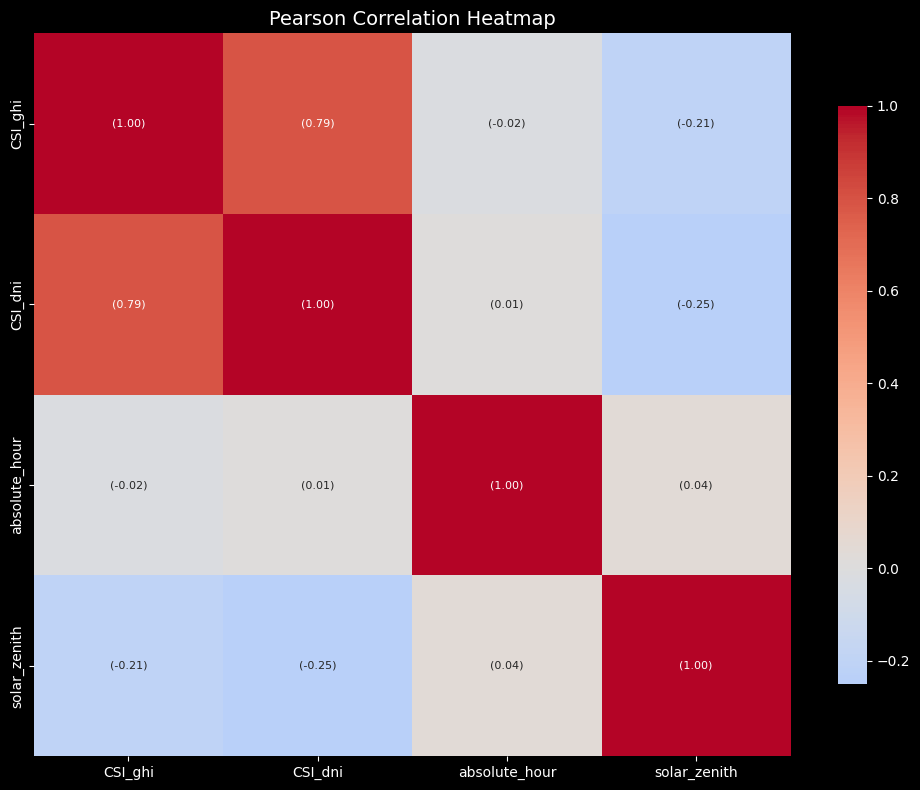

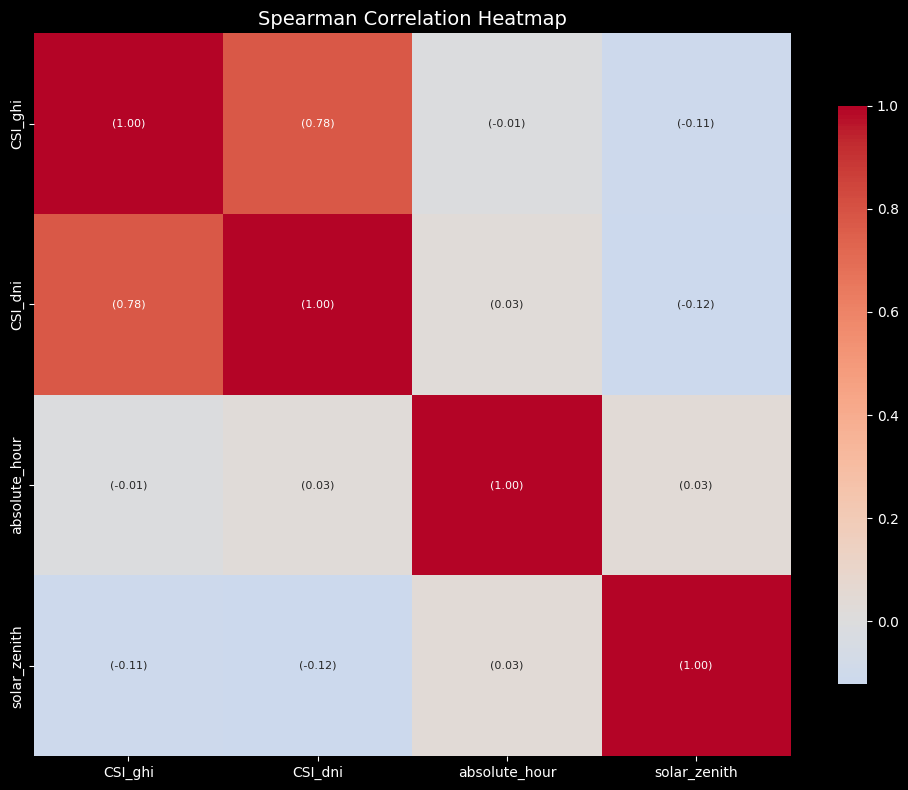

In [32]:
# ---------------- Correlation Analysis ----------------
features = [ 'CSI_ghi', 'CSI_dni',
       'absolute_hour', 'solar_zenith',]  

# 1. Linear Correlation (Pearson) between features
pearson_corr = df_daytime_features[features].corr(method='pearson')
print("\nPearson Correlation Matrix:")
print(pearson_corr)

# 2. Rank-based Correlation (Spearman) - captures monotonic but non-linear relationships
spearman_corr = df_daytime_features[features].corr(method='spearman')
print("\nSpearman Correlation Matrix:")
print(spearman_corr)





# --- Pearson Correlation Heatmap ---
plt.figure(figsize=(10, 8))
sns.heatmap(
    pearson_corr,
    annot=True, fmt=".2f", cmap="coolwarm", center=0,
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 8}
)
# Add parentheses around numbers
for text in plt.gca().texts:
    text.set_text(f"({text.get_text()})")

plt.title("Pearson Correlation Heatmap", fontsize=14)
plt.tight_layout()
plt.show()

# --- Spearman Correlation Heatmap ---
plt.figure(figsize=(10, 8))
sns.heatmap(
    spearman_corr,
    annot=True, fmt=".2f", cmap="coolwarm", center=0,
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 8}
)
for text in plt.gca().texts:
    text.set_text(f"({text.get_text()})")

plt.title("Spearman Correlation Heatmap", fontsize=14)
plt.tight_layout()
plt.show()




Normalized Mutual Information (NMI) matrix between features (0..1):
               CSI_ghi  CSI_dni  absolute_hour  solar_zenith
CSI_ghi          1.000    0.364          0.024         0.245
CSI_dni          0.364    1.000          0.039         0.199
absolute_hour    0.024    0.039          1.000         0.090
solar_zenith     0.245    0.199          0.090         1.000


/Users/muhammadhassan/PycharmProjects/thesis/.venv/lib/python3.14/site-packages/sklearn/preprocessing/_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
/Users/muhammadhassan/PycharmProjects/thesis/.venv/lib/python3.14/site-packages/sklearn/preprocessing/_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/muhammadhassan/PycharmProjects/thesis/.venv/lib/python3.14/site-packages/sklearn/preprocessing/_discretization.py:397: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(


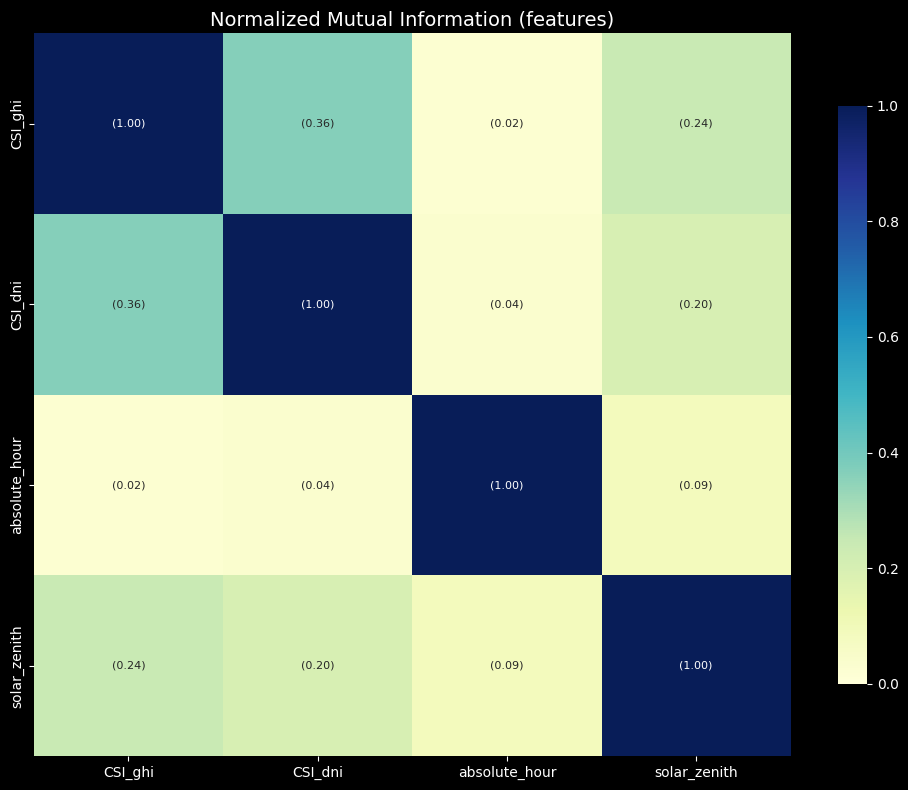

In [33]:
# --- Normalized Mutual Information (NMI) matrix between features + heatmap ---

import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import normalized_mutual_info_score

# PARAMETERS
n_bins = 20                      # default number of quantile bins (tune if needed)
features = [ 'CSI_ghi', 'CSI_dni',
       'absolute_hour', 'solar_zenith',]        # keep same list you used; exclude target if you want
# If you want to exclude target from the matrix, do: features = [f for f in feature_cols if f != 'ghi']

# 1) Prepare data: fill NaNs (use median to avoid distortions)
X = df_daytime_features[features].copy()
X = X.fillna(X.median())

# 2) Determine per-feature bins (avoid more bins than unique values)
bins_per_feature = [min(n_bins, max(2, X[col].nunique())) for col in features]

# 3) Discretize using KBinsDiscretizer (quantile strategy => roughly equal-sized bins)
kbd = KBinsDiscretizer(n_bins=bins_per_feature, encode='ordinal', strategy='quantile')
Xb = kbd.fit_transform(X.values)    # shape = (n_samples, n_features)
Xb = Xb.astype(int)

# 4) Compute normalized mutual information (symmetric matrix)
n = len(features)
nmi_mat = pd.DataFrame(np.zeros((n, n)), index=features, columns=features)

for i in range(n):
    a = Xb[:, i]
    for j in range(i, n):
        b = Xb[:, j]
        # diagonal = perfect self-information
        if i == j:
            val = 1.0
        else:
            # if either variable is constant after discretization, set NMI to 0 (no info)
            if np.unique(a).size <= 1 or np.unique(b).size <= 1:
                val = 0.0
            else:
                # normalized_mutual_info_score returns values in [0,1]
                val = normalized_mutual_info_score(a, b)
        nmi_mat.iloc[i, j] = val
        nmi_mat.iloc[j, i] = val

# Optional: print or inspect numeric matrix
print("\nNormalized Mutual Information (NMI) matrix between features (0..1):")
print(nmi_mat.round(3))

# 5) Plot heatmap with annotations in (0.00) format
plt.figure(figsize=(10, 8))
sns.heatmap(
    nmi_mat,
    annot=True, fmt=".2f", cmap="YlGnBu",
    vmin=0.0, vmax=1.0, cbar_kws={"shrink": 0.8},
    annot_kws={"size": 8}
)
# Put parentheses around each annotated number: (0.00)
ax = plt.gca()
for text in ax.texts:
    text.set_text(f"({text.get_text()})")

plt.title("Normalized Mutual Information (features)", fontsize=14)
plt.tight_layout()
plt.show()

-----
### Merging NAM, and Irradiance. Consistency check

In [34]:
import pandas as pd

def align_and_merge_forecast_utc(
    meas_df,
    nam_df,
    *,
    meas_time_col=None,          # None => use meas_df.index
    nam_time_col='target_time',  # NAM forecast timestamp (UTC target)
    allowed_hours=None,          # e.g., list(range(0,5)) + list(range(14,24))
    nam_hour_lag=1,              # hour-ahead => 1, day-ahead => 24
    nam_hour_shift=0,            # use +1/-1 if hour-ending vs hour-starting
    how='inner',
    floor_to_hour=True
):
    """
    Align and merge measurement data with NAM forecast data.
    
    Parameters:
    -----------
    nam_hour_lag : int
        Forecast lag in hours. Default is 1 (1-hour ahead).
        - For 1-hour ahead: nam_hour_lag=1 (measurement at 15:00 gets NAM at 16:00)
        - For day-ahead: nam_hour_lag=24 (measurement at 15:00 gets NAM at 15:00 next day)
    """
    if allowed_hours is None:
        allowed_hours = list(range(0,5)) + list(range(14,24))

    def _utc_index(df, time_col, who):
        out = df.copy()
        # choose timestamps
        if time_col is None:
            idx_raw = out.index
        else:
            if time_col not in out.columns:
                raise KeyError(f"{who}: column '{time_col}' not found.")
            idx_raw = out[time_col]
        # ensure UTC DatetimeIndex
        idx = pd.DatetimeIndex(pd.to_datetime(idx_raw, errors='coerce'))
        if idx.tz is None:
            idx = idx.tz_localize('UTC')
        else:
            idx = idx.tz_convert('UTC')
        if floor_to_hour:
            idx = idx.floor('h')
        out.index = idx
        # drop bad rows & duplicates after flooring
        out = out[~out.index.isna()]
        out = out[~out.index.duplicated(keep='first')]
        return out

    # 1) Build UTC indices
    meas = _utc_index(meas_df, meas_time_col, "meas_df")
    nam  = _utc_index(nam_df,  nam_time_col,  "nam_df")

    # 2) Shift NAM index so its forecast for T+lag aligns to measurement at T
    #    (alignment index = target_time - lag hours + hour_shift)
    nam = nam.copy()
    nam.index = nam.index - pd.Timedelta(hours=nam_hour_lag) + pd.Timedelta(hours=nam_hour_shift)

    # 3) Filter allowed UTC hours
    meas = meas[meas.index.hour.isin(allowed_hours)]
    nam  = nam[nam.index.hour.isin(allowed_hours)]

    # 4) Merge on measurement timestamps (UTC)
    merged = meas.join(nam, how=how, lsuffix='_meas', rsuffix='_nam')

    # 5) Add explicit time columns and verify forecast relation
    merged = merged.copy()
    merged['measurement_time'] = merged.index

    # Try to expose the original NAM target_time column after merge:
    nam_target_col = (nam_time_col if nam_time_col + '_nam' not in merged.columns
                      else nam_time_col + '_nam')
    if nam_target_col in merged.columns:
        merged['nam_target_time'] = pd.to_datetime(merged[nam_target_col], errors='coerce', utc=True)
        expected = merged['measurement_time'] + pd.Timedelta(hours=nam_hour_lag) - pd.Timedelta(hours=nam_hour_shift)
        mismatches = (merged['nam_target_time'] != expected).sum()
    else:
        mismatches = None

    # Diagnostics
    lag_display = f"{nam_hour_lag} hour(s)" if nam_hour_lag < 24 else f"{nam_hour_lag} hours ({nam_hour_lag//24} day(s))"
    print("="*64)
    print("UTC FORECAST ALIGNMENT")
    print(f"- Measurements (post-filter): {len(meas):,}")
    print(f"- NAM          (post-filter): {len(nam):,}")
    print(f"- Merged rows               : {len(merged):,}")
    print(f"- Alignment applied         : -{lag_display}, +{nam_hour_shift} hour(s) shift")
    if mismatches is not None:
        print(f"- Forecast check mismatches : {mismatches:,} "
              f"(should be 0 if target_time = measurement_time + {nam_hour_lag}h - {nam_hour_shift}h)")
    print(f"- Allowed hours (UTC)       : {allowed_hours}")
    print("="*64)

    return merged

In [35]:


# 1-hour ahead forecast (your requirement)
merged = align_and_merge_forecast_utc(
    meas_df=df_daytime_features,
    nam_df=NAM_nearest_node_day_ahead_long,
    meas_time_col=None,
    nam_time_col='target_time',
    allowed_hours=list(range(0,5)) + list(range(14,24)),
    nam_hour_lag=1,      # measurement at 15:00 gets NAM at 16:00
    nam_hour_shift=0,
    how='inner'
)

UTC FORECAST ALIGNMENT
- Measurements (post-filter): 16,168
- NAM          (post-filter): 15,316
- Merged rows               : 15,078
- Alignment applied         : -1 hour(s), +0 hour(s) shift
- Forecast check mismatches : 0 (should be 0 if target_time = measurement_time + 1h - 0h)
- Allowed hours (UTC)       : [0, 1, 2, 3, 4, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [36]:
merged

,ghi,dni,dhi,solar_zenith,time_gap_hours,time_gap_norm,day_boundary_flag,hour_progression,absolute_hour,GHI_cs,...,month_sin,month_cos,issue_time,target_time,horizon,nam_ghi,nam_dni,nam_cc,measurement_time,nam_target_time
2014-01-03 14:00:00+00:00,0.000,0.000,0.000,100.276,0.167,0.007,0.000,14.492,24.492,0.000,...,0.500,0.866,2014-01-02 12:00:00+00:00,2014-01-03 15:00:00+00:00,27,0.000,0.000,2.000,2014-01-03 14:00:00+00:00,2014-01-03 15:00:00+00:00
2014-01-03 15:00:00+00:00,12.915,89.246,7.185,89.724,0.017,0.001,0.000,15.492,25.492,0.000,...,0.500,0.866,2014-01-02 12:00:00+00:00,2014-01-03 16:00:00+00:00,28,99.625,497.069,2.000,2014-01-03 15:00:00+00:00,2014-01-03 16:00:00+00:00
2014-01-03 16:00:00+00:00,143.776,636.475,34.783,80.147,0.017,0.001,0.000,16.492,26.492,35.159,...,0.500,0.866,2014-01-02 12:00:00+00:00,2014-01-03 17:00:00+00:00,29,274.750,760.163,0.000,2014-01-03 16:00:00+00:00,2014-01-03 17:00:00+00:00
2014-01-03 17:00:00+00:00,289.955,783.193,47.475,71.989,0.017,0.001,0.000,17.492,27.492,184.555,...,0.500,0.866,2014-01-02 12:00:00+00:00,2014-01-03 18:00:00+00:00,30,416.375,871.249,2.000,2014-01-03 17:00:00+00:00,2014-01-03 18:00:00+00:00
2014-01-03 18:00:00+00:00,402.643,843.050,53.397,65.816,0.017,0.001,0.000,18.492,28.492,321.992,...,0.500,0.866,2014-01-02 12:00:00+00:00,2014-01-03 19:00:00+00:00,31,510.875,919.981,8.000,2014-01-03 18:00:00+00:00,2014-01-03 19:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-30 23:00:00+00:00,179.243,520.965,65.012,77.805,0.017,0.001,0.000,23.492,"26,241.492",222.901,...,-0.000,1.000,2016-12-29 12:00:00+00:00,2016-12-31 00:00:00+00:00,36,78.625,243.620,0.000,2016-12-30 23:00:00+00:00,2016-12-31 00:00:00+00:00
2016-12-31 00:00:00+00:00,33.624,71.088,25.460,86.985,0.017,0.001,0.017,0.492,"26,242.492",70.501,...,-0.000,1.000,2016-12-29 12:00:00+00:00,2016-12-31 01:00:00+00:00,37,52.417,162.413,0.000,2016-12-31 00:00:00+00:00,2016-12-31 01:00:00+00:00
2016-12-31 01:00:00+00:00,0.000,0.000,0.303,97.263,0.017,0.001,0.000,1.492,"26,243.492",0.000,...,-0.000,1.000,2016-12-29 12:00:00+00:00,2016-12-31 02:00:00+00:00,38,26.208,81.207,0.000,2016-12-31 01:00:00+00:00,2016-12-31 02:00:00+00:00
2016-12-31 02:00:00+00:00,0.000,0.000,0.003,108.275,0.017,0.001,0.000,2.492,"26,244.492",0.000,...,-0.000,1.000,2016-12-29 12:00:00+00:00,2016-12-31 03:00:00+00:00,39,0.000,0.000,0.000,2016-12-31 02:00:00+00:00,2016-12-31 03:00:00+00:00


In [37]:
cols_to_drop = [
    'dhi', 
    'issue_time', 'target_time', 'horizon'
]

final_df = merged.drop(columns=[c for c in cols_to_drop if c in merged.columns]).copy()

# Ensure measurement_time is datetime and set as index
final_df['measurement_time'] = pd.to_datetime(final_df['measurement_time'], errors='coerce')
final_df = final_df.set_index('measurement_time').sort_index()

In [38]:
final_df

,ghi,dni,solar_zenith,time_gap_hours,time_gap_norm,day_boundary_flag,hour_progression,absolute_hour,GHI_cs,DNI_cs,...,CSI_dni,season_flag,hour_sin,hour_cos,month_sin,month_cos,nam_ghi,nam_dni,nam_cc,nam_target_time
measurement_time,,,,,,,,,,,,,,,,,,,,,
2014-01-03 14:00:00+00:00,0.000,0.000,100.276,0.167,0.007,0.000,14.492,24.492,0.000,0.000,...,NaN,2,-0.500,-0.866,0.500,0.866,0.000,0.000,2.000,2014-01-03 15:00:00+00:00
2014-01-03 15:00:00+00:00,12.915,89.246,89.724,0.017,0.001,0.000,15.492,25.492,0.000,0.000,...,1.200,2,-0.707,-0.707,0.500,0.866,99.625,497.069,2.000,2014-01-03 16:00:00+00:00
2014-01-03 16:00:00+00:00,143.776,636.475,80.147,0.017,0.001,0.000,16.492,26.492,35.159,182.298,...,1.200,2,-0.866,-0.500,0.500,0.866,274.750,760.163,0.000,2014-01-03 17:00:00+00:00
2014-01-03 17:00:00+00:00,289.955,783.193,71.989,0.017,0.001,0.000,17.492,27.492,184.555,540.120,...,1.200,2,-0.966,-0.259,0.500,0.866,416.375,871.249,2.000,2014-01-03 18:00:00+00:00
2014-01-03 18:00:00+00:00,402.643,843.050,65.816,0.017,0.001,0.000,18.492,28.492,321.992,692.514,...,1.200,2,-1.000,-0.000,0.500,0.866,510.875,919.981,8.000,2014-01-03 19:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-30 23:00:00+00:00,179.243,520.965,77.805,0.017,0.001,0.000,23.492,"26,241.492",222.901,597.678,...,0.872,2,-0.259,0.966,-0.000,1.000,78.625,243.620,0.000,2016-12-31 00:00:00+00:00
2016-12-31 00:00:00+00:00,33.624,71.088,86.985,0.017,0.001,0.017,0.492,"26,242.492",70.501,307.571,...,0.231,2,0.000,1.000,-0.000,1.000,52.417,162.413,0.000,2016-12-31 01:00:00+00:00
2016-12-31 01:00:00+00:00,0.000,0.000,97.263,0.017,0.001,0.000,1.492,"26,243.492",0.000,0.000,...,NaN,2,0.259,0.966,-0.000,1.000,26.208,81.207,0.000,2016-12-31 02:00:00+00:00


In [39]:
final_df.to_csv("processed_data/dayTime_NAM_dayahead_features_processed.csv")

In [40]:
final_df.columns

Index(['ghi', 'dni', 'solar_zenith', 'time_gap_hours', 'time_gap_norm',
       'day_boundary_flag', 'hour_progression', 'absolute_hour', 'GHI_cs',
       'DNI_cs', 'CSI_ghi', 'CSI_dni', 'season_flag', 'hour_sin', 'hour_cos',
       'month_sin', 'month_cos', 'nam_ghi', 'nam_dni', 'nam_cc',
       'nam_target_time'],
      dtype='object')

In [41]:
final_df.shape

(15078, 21)

### Add Spatial Features, add more near locations

In [42]:
Folsom_NAM_lat38_599891_lon_121_126680_df = dfs['Folsom_NAM_lat38.599891_lon_121.126680'].reset_index()
Folsom_NAM_lat38_683880_lon_121_286556_df = dfs['Folsom_NAM_lat38.683880_lon_121.286556'].reset_index()
Folsom_NAM_lat38_579454_lon_121_260320_df = dfs['Folsom_NAM_lat38.579454_lon_121.260320'].reset_index()
Folsom_NAM_lat38_704328_lon_121_152788_df = dfs['Folsom_NAM_lat38.704328_lon_121.152788'].reset_index()


In [43]:
Folsom_NAM_lat38_599891_lon_121_126680_df = Folsom_NAM_lat38_599891_lon_121_126680_df[['dwsw', 'valtime', 'cloud_cover']]
Folsom_NAM_lat38_683880_lon_121_286556_df = Folsom_NAM_lat38_683880_lon_121_286556_df[['dwsw', 'valtime', 'cloud_cover']]
Folsom_NAM_lat38_579454_lon_121_260320_df = Folsom_NAM_lat38_579454_lon_121_260320_df[['dwsw', 'valtime', 'cloud_cover']]
Folsom_NAM_lat38_704328_lon_121_152788_df = Folsom_NAM_lat38_704328_lon_121_152788_df[['dwsw', 'valtime', 'cloud_cover']]


In [44]:
Folsom_NAM_lat38_599891_lon_121_126680_df

,dwsw,valtime,cloud_cover
0,0.000,2014-01-02 14:00:00+00:00,4.000
1,0.000,2014-01-02 15:00:00+00:00,2.000
2,96.625,2014-01-02 16:00:00+00:00,0.000
3,272.750,2014-01-02 17:00:00+00:00,0.000
4,422.375,2014-01-02 18:00:00+00:00,10.000
...,...,...,...
14975,79.750,2017-01-01 23:00:00+00:00,100.000
14976,32.500,2017-01-02 00:00:00+00:00,100.000
14977,0.000,2017-01-02 03:00:00+00:00,100.000
14978,0.000,2017-01-02 06:00:00+00:00,50.000


In [45]:
dfs_to_merge = {
    '80': Folsom_NAM_lat38_599891_lon_121_126680_df,
    '56': Folsom_NAM_lat38_683880_lon_121_286556_df,
    '20': Folsom_NAM_lat38_579454_lon_121_260320_df,
    '88': Folsom_NAM_lat38_704328_lon_121_152788_df
}

processed_dfs_list = []
feature_cols = ['dwsw', 'cloud_cover'] # Columns to rename

for suffix, df in dfs_to_merge.items():
    # Create the rename mapping, e.g., {'dwsw': '80_dwsw', 'cloud_cover': '80_cloud_cover'}
    rename_map = {col: f"{suffix}_{col}" for col in feature_cols}
    
    # Apply the renaming and add the DataFrame to our list
    renamed_df = df.rename(columns=rename_map)
    processed_dfs_list.append(renamed_df)

In [46]:
merged_df = processed_dfs_list[0]

# Loop through the rest and merge them in
for df_to_add in processed_dfs_list[1:]:
    merged_df = pd.merge(merged_df, df_to_add, on='valtime', how='outer')
merged_df = merged_df.sort_values(by='valtime').reset_index(drop=True)

# Check your final DataFrame
merged_df.head()

,80_dwsw,valtime,80_cloud_cover,56_dwsw,56_cloud_cover,20_dwsw,20_cloud_cover,88_dwsw,88_cloud_cover
0,0.000,2014-01-02 14:00:00+00:00,4.000,0.000,2.000,0.000,2.000,0.000,2.000
1,0.000,2014-01-02 15:00:00+00:00,2.000,0.000,0.000,0.000,0.000,0.000,2.000
2,96.625,2014-01-02 16:00:00+00:00,0.000,93.500,0.000,95.000,0.000,95.250,0.000
3,272.750,2014-01-02 17:00:00+00:00,0.000,269.125,0.000,270.875,0.000,270.875,0.000
4,422.375,2014-01-02 18:00:00+00:00,10.000,418.750,18.000,420.750,16.000,420.375,16.000


In [47]:
merged_df.columns

Index(['80_dwsw', 'valtime', '80_cloud_cover', '56_dwsw', '56_cloud_cover',
       '20_dwsw', '20_cloud_cover', '88_dwsw', '88_cloud_cover'],
      dtype='object')

In [48]:
df_daytime_features

,ghi,dni,dhi,solar_zenith,time_gap_hours,time_gap_norm,day_boundary_flag,hour_progression,absolute_hour,GHI_cs,DNI_cs,CSI_ghi,CSI_dni,season_flag,hour_sin,hour_cos,month_sin,month_cos
timeStamp,,,,,,,,,,,,,,,,,,
2014-01-02 14:00:00+00:00,0.000,0.000,0.000,100.251,0.017,0.001,0.017,14.492,0.492,0.000,0.000,NaN,NaN,2,-0.500,-0.866,0.500,0.866
2014-01-02 15:00:00+00:00,12.936,88.453,7.261,89.712,0.017,0.001,0.000,15.492,1.492,0.000,0.000,1.200,1.200,2,-0.707,-0.707,0.500,0.866
2014-01-02 16:00:00+00:00,146.646,631.312,39.014,80.152,0.017,0.001,0.000,16.492,2.492,35.342,184.033,1.200,1.200,2,-0.866,-0.500,0.500,0.866
2014-01-02 17:00:00+00:00,287.115,709.660,68.391,72.015,0.017,0.001,0.000,17.492,3.492,184.547,541.559,1.200,1.200,2,-0.966,-0.259,0.500,0.866
2014-01-02 18:00:00+00:00,390.230,782.010,66.265,65.869,0.017,0.001,0.000,18.492,4.492,321.572,693.506,1.200,1.128,2,-1.000,-0.000,0.500,0.866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 00:00:00+00:00,33.624,71.088,25.460,86.985,0.017,0.001,0.017,0.492,"26,242.492",70.501,307.571,0.477,0.231,2,0.000,1.000,-0.000,1.000
2016-12-31 01:00:00+00:00,0.000,0.000,0.303,97.263,0.017,0.001,0.000,1.492,"26,243.492",0.000,0.000,NaN,NaN,2,0.259,0.966,-0.000,1.000
2016-12-31 02:00:00+00:00,0.000,0.000,0.003,108.275,0.017,0.001,0.000,2.492,"26,244.492",0.000,0.000,NaN,NaN,2,0.500,0.866,-0.000,1.000


In [49]:




# 1-hour ahead forecast (your requirement)
merged_spatial = align_and_merge_forecast_utc(
    meas_df=merged,
    nam_df=merged_df,
    meas_time_col=None,
    nam_time_col='valtime',
    allowed_hours=list(range(0,5)) + list(range(14,24)),
    nam_hour_lag=1,      # measurement at 15:00 gets NAM at 16:00
    nam_hour_shift=0,
    how='inner'
)

UTC FORECAST ALIGNMENT
- Measurements (post-filter): 15,078
- NAM          (post-filter): 11,770
- Merged rows               : 11,561
- Alignment applied         : -1 hour(s), +0 hour(s) shift
- Forecast check mismatches : 0 (should be 0 if target_time = measurement_time + 1h - 0h)
- Allowed hours (UTC)       : [0, 1, 2, 3, 4, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [50]:
merged_spatial

,ghi,dni,dhi,solar_zenith,time_gap_hours,time_gap_norm,day_boundary_flag,hour_progression,absolute_hour,GHI_cs,...,nam_target_time,80_dwsw,valtime,80_cloud_cover,56_dwsw,56_cloud_cover,20_dwsw,20_cloud_cover,88_dwsw,88_cloud_cover
2014-01-03 14:00:00+00:00,0.000,0.000,0.000,100.276,0.167,0.007,0.000,14.492,24.492,0.000,...,2014-01-03 15:00:00+00:00,0.000,2014-01-03 15:00:00+00:00,2.000,0.000,4.000,0.000,0.000,0.000,8.000
2014-01-03 15:00:00+00:00,12.915,89.246,7.185,89.724,0.017,0.001,0.000,15.492,25.492,0.000,...,2014-01-03 16:00:00+00:00,99.625,2014-01-03 16:00:00+00:00,2.000,97.375,2.000,95.000,0.000,102.000,6.000
2014-01-03 16:00:00+00:00,143.776,636.475,34.783,80.147,0.017,0.001,0.000,16.492,26.492,35.159,...,2014-01-03 17:00:00+00:00,274.750,2014-01-03 17:00:00+00:00,0.000,273.375,0.000,274.125,0.000,279.000,2.000
2014-01-03 17:00:00+00:00,289.955,783.193,47.475,71.989,0.017,0.001,0.000,17.492,27.492,184.555,...,2014-01-03 18:00:00+00:00,416.375,2014-01-03 18:00:00+00:00,2.000,411.500,0.000,417.500,4.000,410.375,0.000
2014-01-03 18:00:00+00:00,402.643,843.050,53.397,65.816,0.017,0.001,0.000,18.492,28.492,321.992,...,2014-01-03 19:00:00+00:00,510.875,2014-01-03 19:00:00+00:00,8.000,508.125,4.000,509.875,12.000,508.750,2.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-30 20:00:00+00:00,449.525,747.595,99.078,62.079,0.017,0.001,0.000,20.492,"26,238.492",448.964,...,2016-12-30 21:00:00+00:00,453.875,2016-12-30 21:00:00+00:00,0.000,452.625,0.000,454.000,0.000,452.500,0.000
2016-12-30 21:00:00+00:00,410.877,735.498,96.407,64.766,0.017,0.001,0.000,21.492,"26,239.492",427.167,...,2016-12-30 22:00:00+00:00,370.250,2016-12-30 22:00:00+00:00,0.000,370.500,0.000,371.250,0.000,369.750,0.000
2016-12-30 22:00:00+00:00,313.067,684.428,79.502,70.203,0.017,0.001,0.000,22.492,"26,240.492",349.110,...,2016-12-30 23:00:00+00:00,236.500,2016-12-30 23:00:00+00:00,0.000,237.375,0.000,238.000,0.000,236.000,0.000
2016-12-30 23:00:00+00:00,179.243,520.965,65.012,77.805,0.017,0.001,0.000,23.492,"26,241.492",222.901,...,2016-12-31 00:00:00+00:00,78.625,2016-12-31 00:00:00+00:00,0.000,79.250,0.000,79.875,0.000,78.125,0.000


In [51]:
merged_spatial.to_csv("processed_data/dayTime_NAM_spatial_5locations_dayahead_features_processed.csv")

In [52]:
merged_spatial.columns

Index(['ghi', 'dni', 'dhi', 'solar_zenith', 'time_gap_hours', 'time_gap_norm',
       'day_boundary_flag', 'hour_progression', 'absolute_hour', 'GHI_cs',
       'DNI_cs', 'CSI_ghi', 'CSI_dni', 'season_flag', 'hour_sin', 'hour_cos',
       'month_sin', 'month_cos', 'issue_time', 'target_time', 'horizon',
       'nam_ghi', 'nam_dni', 'nam_cc', 'measurement_time', 'nam_target_time',
       '80_dwsw', 'valtime', '80_cloud_cover', '56_dwsw', '56_cloud_cover',
       '20_dwsw', '20_cloud_cover', '88_dwsw', '88_cloud_cover'],
      dtype='object')